In [1]:
import pandas as pd
import geopandas as gpd
import folium
from folium.features import GeoJsonPopup, GeoJsonTooltip
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline

df_athletes_medals = pd.read_csv('./datos_clean/olympic_athletes_medals.csv')
df_hosts = pd.read_csv('./datos/olympic_hosts.csv')
df_results = pd.read_csv('./datos/olympic_results.csv')

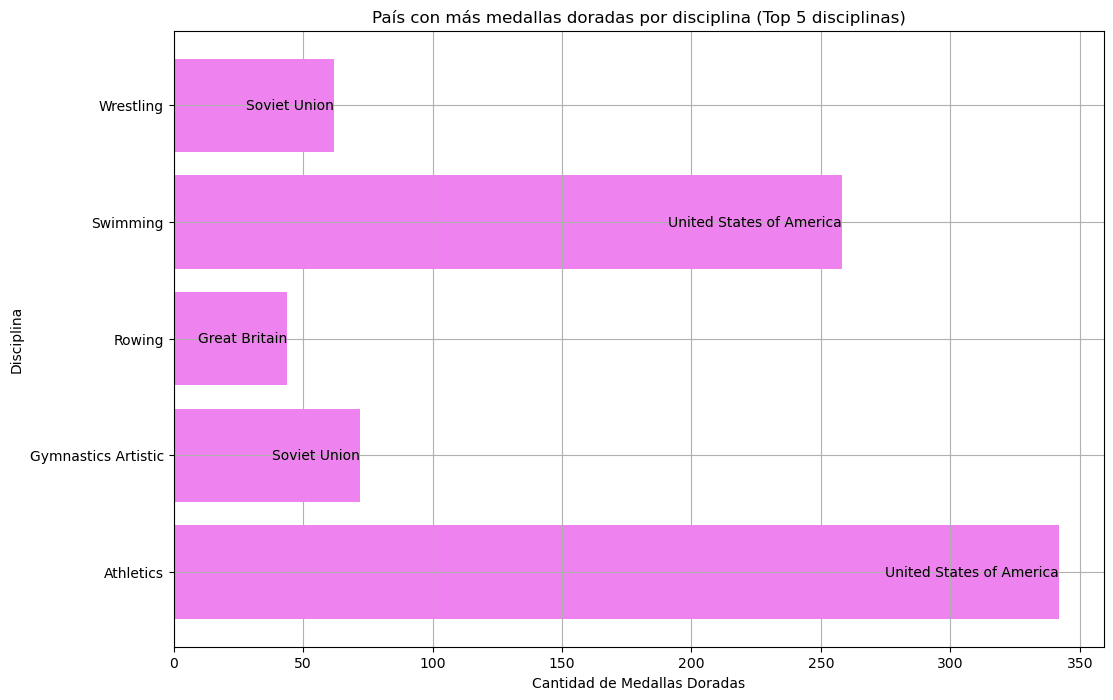

In [2]:
# ======= 1) PAISES CON MAS MEDALLAS DORADAS POR DISCIPLINA (TOP 5 DISCIPLINAS) =======

# Filtramos solo las medallas doradas
gold_medals = df_athletes_medals[df_athletes_medals['medal_type'] == 'GOLD']

# Agrupamos por disciplina y contamos las medallas doradas
top_disciplines = gold_medals['discipline_title'].value_counts().head(5).index

# Solo las top 5 disciplinas
top_gold_medals = gold_medals[gold_medals['discipline_title'].isin(top_disciplines)]

# Hacemos un count y agrupamos por país
gold_medals_count = top_gold_medals.groupby(['discipline_title', 'country_name']).size().reset_index(name='count')

# Conseguimos el top país
top_gold_countries = gold_medals_count.loc[gold_medals_count.groupby('discipline_title')['count'].idxmax()]

# Creamos el gráfico
plt.figure(figsize=(12, 8))
plt.barh(top_gold_countries['discipline_title'], top_gold_countries['count'], color='violet')
plt.xlabel('Cantidad de Medallas Doradas')
plt.ylabel('Disciplina')
plt.title('País con más medallas doradas por disciplina (Top 5 disciplinas)')
plt.grid(True)

# Etiquetas con los nombres de los países
for index, value in enumerate(top_gold_countries['count']):
    plt.text(value, index, str(top_gold_countries['country_name'].iloc[index]), va='center', ha='right', color='black', fontsize=10)

plt.show()

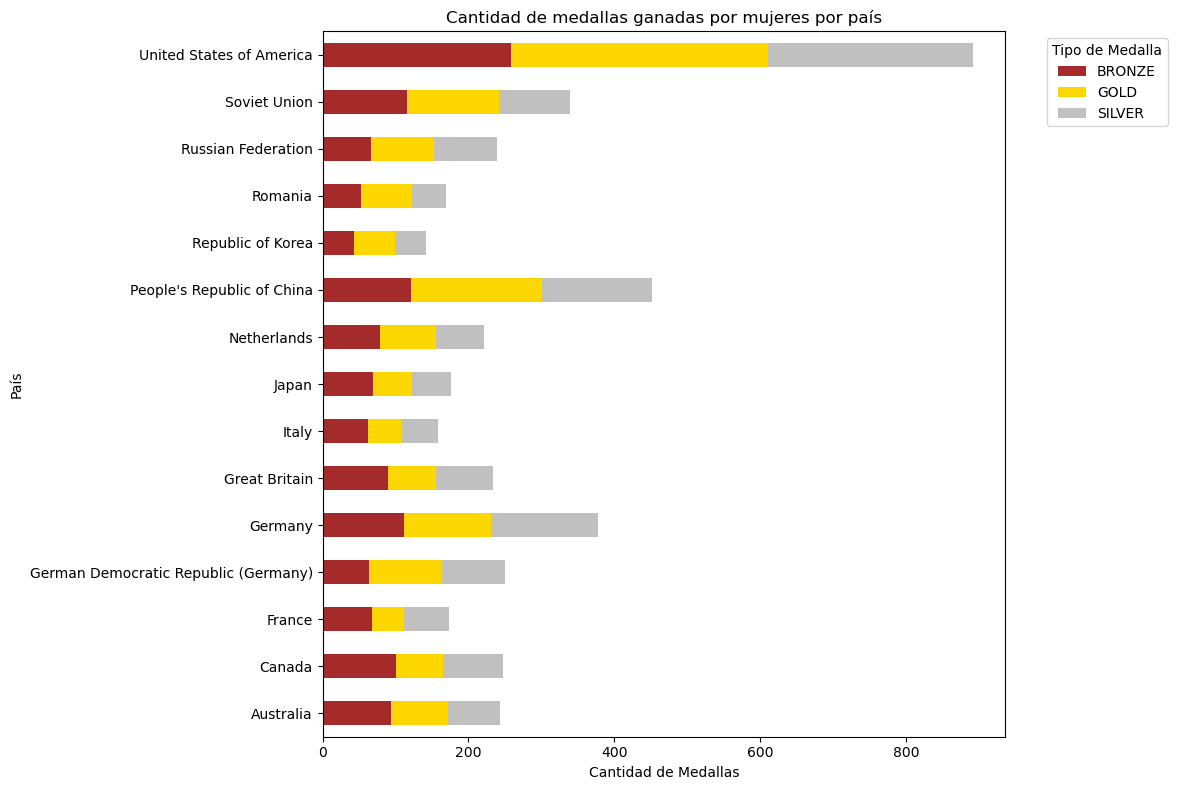

In [3]:
# ======= 2) CONTEO DE MEDALLAS DE MUJERES (TOP 15 Países) =======

# Filtramos solo las medallas ganadas por mujeres
women_medals = df_athletes_medals[df_athletes_medals['event_gender'] == 'Women']

# Agrupamos por país y los contamos
top_disciplines = women_medals['country_name'].value_counts().head(15).index

# Solo las top 15 países
top_women = women_medals[women_medals['country_name'].isin(top_disciplines)]

# Agrupar por país y tipo de medalla
medals_count = top_women.groupby(['country_name', 'medal_type']).size().unstack(fill_value=0)

# Crear el gráfico de barras apiladas
medals_count.plot(kind='barh', stacked=True, color={'GOLD': 'gold', 'SILVER': 'silver', 'BRONZE': 'brown'}, figsize=(12, 8))

# Añadir etiquetas y título
plt.xlabel('Cantidad de Medallas')
plt.ylabel('País')
plt.title('Cantidad de medallas ganadas por mujeres por país')
plt.legend(title='Tipo de Medalla', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [5]:
# ======= 3) CANTIDAD DE ATLETAS MEDALLISTAS DE ORO POR PAÍS EN MAPA =======

# Filtramos solo las medallas doradas
gold_medals = df_athletes_medals[df_athletes_medals['medal_type'] == 'GOLD']

# Agrupamos por país y contar los atletas
athletes_count = gold_medals['country_name'].value_counts().reset_index()
athletes_count.columns = ['country_name', 'athlete_count']

# Cargamos un shapefile del mundo (en este caso agarramos uno default)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Unimos el DataFrame de atletas con el GeoDataFrame del mundo
world = world.merge(athletes_count, how='left', left_on='name', right_on='country_name')

# Creamos el mapa interactivo
map = folium.Map(location=[20, 0], zoom_start=2)

folium.Choropleth(
    geo_data=world,
    name='choropleth',
    data=world,
    columns=['name', 'athlete_count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Cantidad de Atletas'
).add_to(map)

folium.GeoJson(
    world,
    style_function=lambda x: {'fillColor': '#ffffff00', 'color': 'black', 'weight': 0.5},
    tooltip=GeoJsonTooltip(
        fields=['name', 'athlete_count'],
        aliases=['País', 'Cantidad de Atletas'],
        localize=True
    ),
    popup=GeoJsonPopup(
        fields=['name', 'athlete_count'],
        aliases=['País', 'Cantidad de Atletas'],
        localize=True
    )
).add_to(map)

# Mostramos el mapa
map

C:\Users\pablo\AppData\Local\Temp\ipykernel_20968\961220996.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


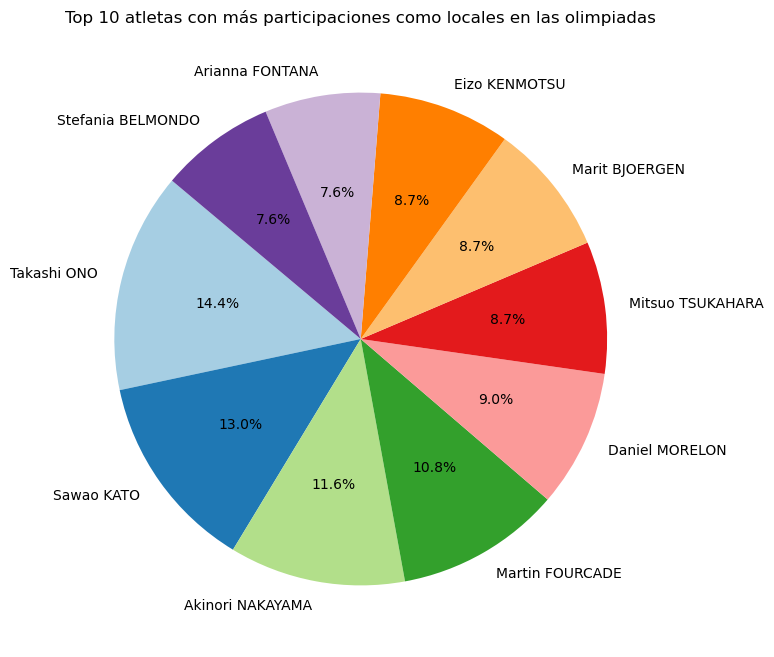

In [6]:
# ======= 4) TOP 10 ATLETAS CON MÁS PARTICIPACIONES COMO LOCALES EN LAS OLIMPIADAS =======

# Unimos los DataFrames en base a los juegos olímpicos
df_merged = pd.merge(df_athletes_medals, df_hosts, left_on='country_name', right_on='game_location')

# Filtramos los atletas locales
df_locals = df_merged[df_merged['country_name'] == df_merged['game_location']]

# Contamos las participaciones de los atletas locales
local_athletes_count = df_locals['athlete_full_name'].value_counts().head(10)

# Creamos el gráfico de pie chart
plt.figure(figsize=(10, 8))
local_athletes_count.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.ylabel('')
plt.title('Top 10 atletas con más participaciones como locales en las olimpiadas')
plt.show()

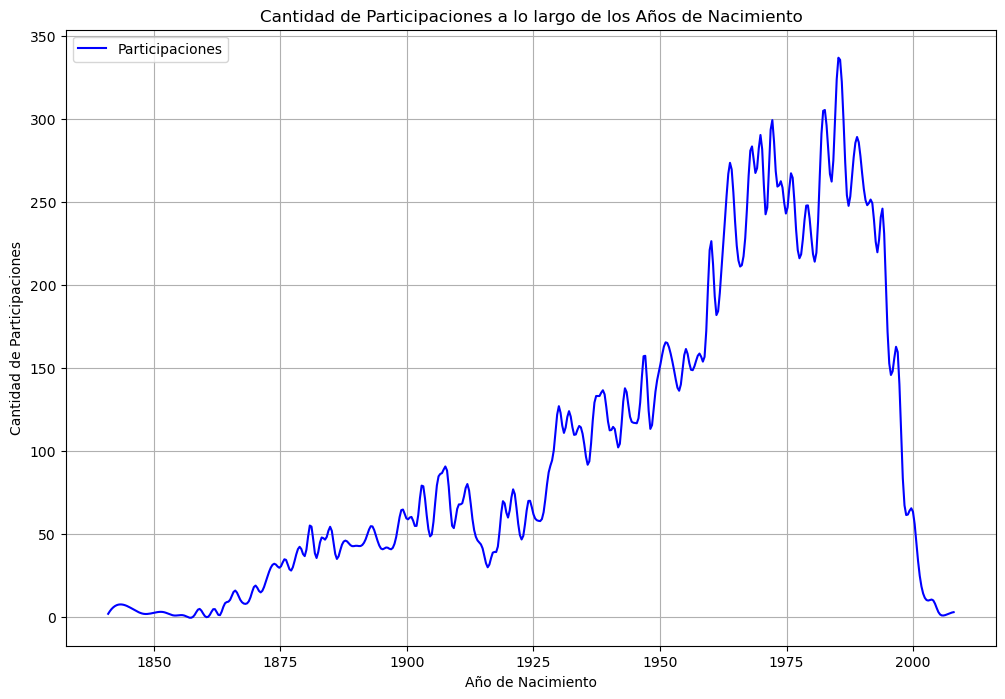

In [7]:
# ======= 5) CANTIDAD DE PARTICIPACIONES A LO LARGO DE LOS AÑOS DE NACIMIENTO =======

# Agrupamos por año de nacimiento y contar las participaciones
participations_per_year = df_athletes_medals.groupby('athlete_year_birth').size().reset_index(name='participations')

# Ordenamos los datos por año de nacimiento
participations_per_year = participations_per_year.sort_values('athlete_year_birth')

# Creamos una curva suave usando interpolación
x = participations_per_year['athlete_year_birth']
y = participations_per_year['participations']
X_Y_Spline = make_interp_spline(x, y)

# Generamos nuevos valores X e Y
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

# Creamos la gráfica de línea
plt.figure(figsize=(12, 8))
plt.plot(X_, Y_, label='Participaciones', color='blue')
plt.xlabel('Año de Nacimiento')
plt.ylabel('Cantidad de Participaciones')
plt.title('Cantidad de Participaciones a lo largo de los Años de Nacimiento')
plt.legend()
plt.grid(True)
plt.show()